## Application: Face detection

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme();
plt.rcParams['figure.figsize'] = (12, 8)

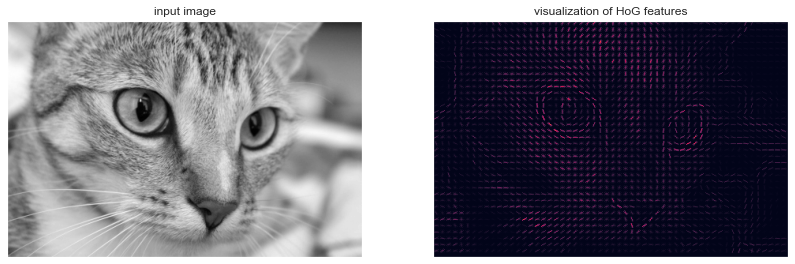

In [3]:
## Feature Extraction : HOG
# HoG: Created to identify pedestrians within images
# 1 - Pre-normalize the images -> Suppress illumination dependance
# 2 - Convolve image with filters -> Capture edfe, contour and texture information
# 3 - Subdivide the image into CELLS. Compute an histogram of the gradient orientation with each cell
# 4 - Normalize histograms by comparing to the blocks of neighbording cells -> Suppress effect of illumination
# 5 - Construct a 1D feature vector from the informaiton in each cell

# skimage = Collection of algorithms for image processing
from skimage import data, color, feature
import skimage.data

# Take an example of a picture of a cat(RGB) and convert it into grayscale image
image = color.rgb2gray(data.chelsea())
# Apply HoG feature extraction
hog_vec, hog_vis = feature.hog(image, visualize=True)

fig, ax = plt.subplots(1, 2, figsize=(14, 8),
                       subplot_kw={"xticks": [], "yticks": []})
# Plot the image
ax[0].imshow(image, cmap="gray")
ax[0].set_title("input image")

# Plot the HoG image
ax[1].imshow(hog_vis)
ax[1].set_title("visualization of HoG features");

#### SVM: as a face detector

- Plan:

1. Get a set of positive(with face) and negative(without face) training set
2. Extract HoG features vector from training set
3. Train SVM classifier
4. Given a new image, pass a "sliding window" across the image. Use the model to evaluate if the window contains a face of not

In [4]:
# 1 - Get training set

## Positive training set
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_images = faces.images
positive_images_shape = positive_images[0].shape
print(f"Shape of positive training set: {positive_images.shape}")
print(f"Shape of a single image: {positive_images_shape}\n")

## Negative training set
# Need a set of similarly sized images without any face in them
from skimage import data, transform

categories = ['camera', 'text', 'coins', 'moon','page', 'clock',
              'immunohistochemistry', 'chelsea', 'coffee', 'hubble_deep_field']
# data attributes are function to retrieve a category of images
negative_original_images = np.array([color.rgb2gray(getattr(data, c)()) for c in categories])
for idx, c in enumerate(categories):  
    print(f"Shape of {c} in negative training set: {negative_original_images[idx].shape}") 

# Negative training set contains only 10 pictures
# -> Extract patch from them to end up with as much negative images as positive images
# -> Make sure the size of each negative image match the size of the positive image (i.e. 62*47)

from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_final_size=positive_images_shape):
    # Create tuple with desired patch size
    patch_size = tuple((scale*np.array(patch_final_size)).astype(int))
    print(f"\nImage size: {img.shape}")
    print(f"Patch size: {patch_size}")
    # Create patch extractor
    extractor = PatchExtractor(patch_size=patch_size, # Dimension of 1 patch
                               max_patches=N, # Maximum number of patches per image to extract
                               random_state=0)
    # Transform the image into patches -> return array of shape (n_samples, height, width)
    patches = extractor.transform(img[np.newaxis]) # (height, width) -> (1, height, width)
    print(f"Shape of patches before resizing: {patches.shape}")
    if scale != 1:
        # Resize each sample to positive image size by interpolation
        patches = np.array([transform.resize(patch, patch_final_size) for patch in patches])
    print(f"Shape of patches after resizing: {patches.shape}")

    return patches
    
# Generate the entire negative training set from our 10 original negative images
# Extract at most 1'000*3 patches from each negative images -> at most 30'000 negative images in total
negative_images = np.vstack([extract_patches(im, 1000, scale)
                             for im in negative_original_images
                             for scale in [0.5, 1.0, 2.0]])
print(f"\nShape of negative images: {negative_images.shape}")

Shape of positive training set: (13233, 62, 47)
Shape of a single image: (62, 47)



/Users/nicolas/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/nicolas/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Shape of camera in negative training set: (512, 512)
Shape of text in negative training set: (172, 448)
Shape of coins in negative training set: (303, 384)
Shape of moon in negative training set: (512, 512)
Shape of page in negative training set: (191, 384)
Shape of clock in negative training set: (300, 400)
Shape of immunohistochemistry in negative training set: (512, 512)
Shape of chelsea in negative training set: (300, 451)
Shape of coffee in negative training set: (400, 600)
Shape of hubble_deep_field in negative training set: (872, 1000)

Image size: (512, 512)
Patch size: (31, 23)
Shape of patches before resizing: (1000, 31, 23)
Shape of patches after resizing: (1000, 62, 47)

Image size: (512, 512)
Patch size: (62, 47)
Shape of patches before resizing: (1000, 62, 47)
Shape of patches after resizing: (1000, 62, 47)

Image size: (512, 512)
Patch size: (124, 94)
Shape of patches before resizing: (1000, 124, 94)
Shape of patches after resizing: (1000, 62, 47)

Image size: (172, 448)

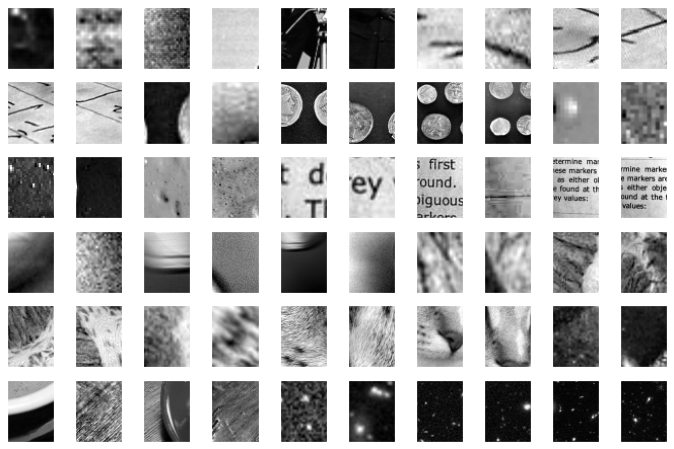

In [5]:
# Visualize negative training set
fig, axes = plt.subplots(6, 10,
                         subplot_kw={"xticks": [], "yticks": []})
for idx, ax in enumerate(axes.flat):
    ax.imshow(negative_images[500*idx], cmap="gray")

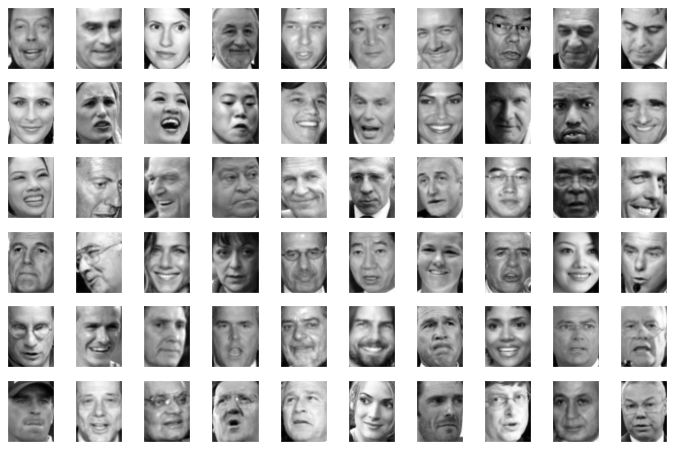

In [6]:
# Visualize positive training set
fig, axes = plt.subplots(6, 10,
                         subplot_kw={"xticks": [], "yticks": []})
for idx, ax in enumerate(axes.flat):
    ax.imshow(positive_images[200*idx], cmap="gray")

In [7]:
## 2 - Combining negative and positive images into training set & Extract HoG features
from itertools import chain

# chain returns an iterative s.t. next() method return elements form the 1st iteration until it is exhausted
# then element from the next iterable and so on.
images = chain(positive_images, negative_images)

# Construct feature matrix
X_train = np.array([feature.hog(image) for image in images])
# Construct label array
y_train = np.zeros(X_train.shape[0])
y_train[:positive_images.shape[0]] = 1 # 1 means the image contains a face

In [8]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

# -> Data it ready to be passed into SVM classfier
# n_samples = 43'233 // n_features = 1'215

Shape of X_train: (43233, 1215)
Shape of y_train: (43233,)


In [9]:
## 3 - Train SVM Classifier
# SVM works well with high-dimensional dataset
# Use LinearSVC because it has better scaling than SVC for large number of sample
# LinearSVC = SVC with kernel="linear"

# 3.1 First let's use a simple Gaussian Naive Bayes to get a quick baseline
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

# cross_val_score = Evaluate a model by cross-validation, by default cv = 3
baseline_scores = cross_val_score(GaussianNB(), X_train, y_train)
print(f"Baseline Gaussian Naive Bayes scores: {baseline_scores}")

# 3.2 SVM with GridSearchCV for the softening parameter
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(LinearSVC(),
                    {"C": [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
print(f"Best params: {grid.best_params_} with score: {grid.best_score_}")




/Users/nicolas/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Baseline Gaussian Naive Bayes scores: [0.95385469 0.97349247 0.97501908]


/Users/nicolas/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/nicolas/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/nicolas/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/nicolas/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/nicolas/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:922

Best params: {'C': 1.0} with score: 0.9891286748548562


In [10]:
# Extract the best model from GridSearch and re-train it on the full dataset
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Shape of test_image (512, 512)
Shape of rescaled test_image (256, 256)

Shape of the image passed: (160, 140)
Final size of the patch: (62, 47)


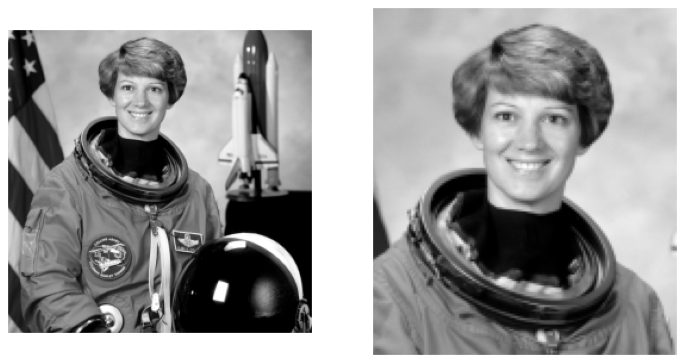

In [92]:
# 4 - Test our model on new images

test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
print(f"Shape of test_image {test_image.shape}")
# Make the image twice smaller
test_image = skimage.transform.rescale(test_image, 0.5)
print(f"Shape of rescaled test_image {test_image.shape}")

fig, axes = plt.subplots(1, 2, subplot_kw={"xticks": [], "yticks": []})
axes[0].imshow(test_image, cmap='gray')

# Truncate the image on the section we are interested in
test_image = test_image[:160, 40:180]
axes[1].imshow(test_image, cmap='gray');

# Create a sliding window that iterates over patches of this image.
# Compute HoG features for each patch and use our model to classify it(face or without face)

def sliding_window(img, patch_final_size=positive_images_shape, height_step=2, width_step=2, scale = 1):
    """
    Create patches on the img
    Args:
        img: image on which to extract patches
        patch_final_size: size of the patch image that should be returned
        height_step: Height increment of the sliding window
        width_step: Width increment of the sliding window
        scale: Scaling factor between sliding window shape and patch final shape
    """
    # Define the final width and height of the patch
    patch_height, patch_width = (int(scale*s) for s in patch_final_size)
    img_height = img.shape[0]
    img_width = img.shape[1]
    # Loop over the image
    for i in range(0, img_height - patch_height, height_step):
        for j in range(0, img_width - patch_width, width_step):
            # Extract the patch
            patch = img[i:i+patch_height, j:j+patch_width]
            if scale != 1:
                # Restore patch shape to expected patch shape
                patch = transform.resize(patch, patch_final_size)
            yield (i, j), patch # Generator function so that we don't store the entire patches in memory

print(f"\nShape of the image passed: {test_image.shape}")
print(f"Final size of the patch: {positive_images_shape}")
# zip(a,b,c,...): Return an iterator of tuples, each call returns a tuple where the elements of the i-th tuple
# comes from the i-th element of a, b, c, ...
indices, patches = zip(*sliding_window(test_image))
# Compute the HoG feature for all the patches
patches_hog = np.array([feature.hog(patch) for patch in patches])

Shape of the training set: (43233, 1215)
Shape of the test set: (2303, 1215)
Shape of y_model: (2303,)
Number of patches with face: 49.0
Number of patches with face: 2254.0
Shape of patches_face: (49, 62, 47)


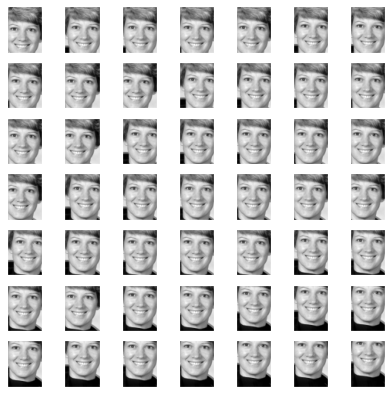

In [93]:
# Evaluate our model on new data
print(f"Shape of the training set: {X_train.shape}")
print(f"Shape of the test set: {patches_hog.shape}")

y_model = model.predict(patches_hog)
print(f"Shape of y_model: {y_model.shape}")
print(f"Number of patches with face: {np.sum(y_model)}")
print(f"Number of patches with face: {np.sum(1-y_model)}")

# Extract the patches identified with a face:
patches=np.array(patches) # Cast iterator into a array
patches_face=patches[y_model == 1]
print(f"Shape of patches_face: {patches_face.shape}")

fig, axes = plt.subplots(7, 7, figsize=(7,7),
                         subplot_kw={"xticks": [], "yticks": []})
for idx, ax in enumerate(axes.flat):
    ax.imshow(patches_face[idx], cmap='gray')

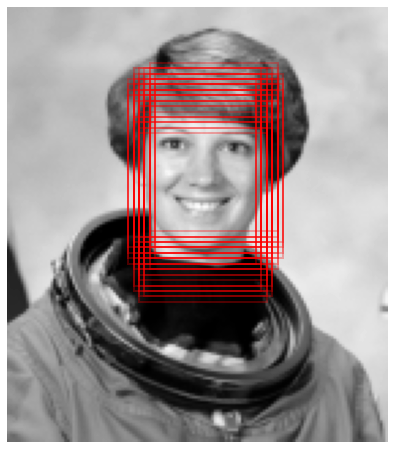

In [94]:
# Look at the the true patches location on original image
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis("off")

indices = np.array(indices)
true_indices = indices[y_model == 1]

for i, j in true_indices:
    ax.add_artist(plt.Rectangle((j, i), # Our j coordonate correspond to x-axis
                                 positive_images_shape[1],
                                 positive_images_shape[0],
                                 edgecolor = "red",
                                 alpha=0.3,
                                 lw=2,
                                 facecolor='none'
                                 ))

In [87]:
# Possible improvements:

# -> Fix false positive with hard negative mining
# -> Add a final layer: clustering algorithm to avoid overlap (30 patches detects the same face)
# -> Bundle all steps into a pipeline
# -> Use a Neural Network (enable optimal feature extraction rather than relying on our intuition)

#### Concept Summary:

- Feature extraction:
    - HOG: Histogram of Oriented Gradients: Algorithm to extract features from an image
    
- Sliding window for identification: Extract patches from test image. Patches are passed to the model for predictions

- Hard negative mining: Take all patches representing false positive and add them to our negative training set, and re-train de classifier